In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Task 3: Customer Segmentation / Clustering**

**Step 1: Import necassary libraries:-**


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist




**Step 2: Load and Preprocess Data**

**Load Datasets :**
We will load the Customers.csv and Transactions.csv files and merge them based on CustomerID to form a complete dataset.

In [8]:
# Load datasets from Google Drive
customers_df = pd.read_csv('/content/drive/MyDrive/Customers.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/Transactions.csv')

# Merge datasets on CustomerID to get a complete view of customers
df = pd.merge(transactions_df, customers_df, on="CustomerID")

# Display the first few rows
df.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


**Handle Categorical Data :**
Categorical columns such as SignupDate and Region will be one-hot encoded to convert them into numerical values.

In [9]:
# Categorical columns to encode
categorical_cols = ['SignupDate', 'Region']

# Apply OneHotEncoder
encoder = OneHotEncoder()
encoded_cols = encoder.fit_transform(df[categorical_cols]).toarray()

# Convert encoded data into a dataframe
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out())

# Concatenate encoded columns with original data and drop categorical columns
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)


**Normalize Numerical Data :**
We will scale numerical features to ensure consistent units across all columns. Scaling helps clustering algorithms perform better.

In [10]:
# Numerical columns for scaling
numerical_cols = ['Quantity', 'TotalValue', 'Price']

# Standardizing numerical data
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Preview processed data
df.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,SignupDate_2022-01-22,SignupDate_2022-02-02,...,SignupDate_2024-11-11,SignupDate_2024-11-13,SignupDate_2024-11-15,SignupDate_2024-11-18,SignupDate_2024-11-22,SignupDate_2024-12-28,Region_Asia,Region_Europe,Region_North America,Region_South America
0,T00001,C0199,P067,2024-08-25 12:38:23,-1.375488,-0.789850,0.199948,Andrea Jenkins,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,T00112,C0146,P067,2024-05-27 22:23:54,-1.375488,-0.789850,0.199948,Brittany Harvey,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,T00166,C0127,P067,2024-04-25 07:38:55,-1.375488,-0.789850,0.199948,Kathryn Stevens,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,T00272,C0087,P067,2024-03-26 22:55:37,-0.480571,-0.179825,0.199948,Travis Campbell,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,T00363,C0070,P067,2024-03-21 15:10:10,0.414347,0.430200,0.199948,Timothy Perez,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Step 3: Apply Clustering (K-Means):**
We will use the K-Means algorithm for segmentation. The optimal number of clusters will be determined using the Elbow Method.

**Determine Optimal Number of Clusters**

In [11]:
import numpy as np


print(df.isnull().sum().sum())  # Check total missing values
df.dropna(inplace=True)  # Drop missing values if any
print(df.dtypes)  # Check column data types
df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
#Ensure that numerical features are scaled properly for clustering.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


0
TransactionID             object
CustomerID                object
ProductID                 object
TransactionDate           object
Quantity                 float64
                          ...   
SignupDate_2024-12-28    float64
Region_Asia              float64
Region_Europe            float64
Region_North America     float64
Region_South America     float64
Length: 190, dtype: object


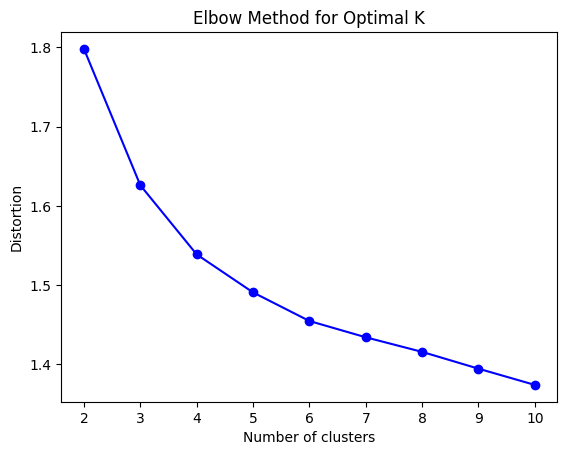

In [14]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
# Determine optimal number of clusters using Elbow Method
distortions = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    distortions.append(sum(np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

# Plot the elbow curve
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

**Fit K-Means Model:**
Based on the Elbow Method, we will choose an optimal number of clusters and fit the model.

In [17]:
print(df.columns)



Index(['Quantity', 'TotalValue', 'Price', 'SignupDate_2022-01-22',
       'SignupDate_2022-02-02', 'SignupDate_2022-02-10',
       'SignupDate_2022-02-13', 'SignupDate_2022-02-19',
       'SignupDate_2022-02-25', 'SignupDate_2022-02-27',
       ...
       'SignupDate_2024-11-11', 'SignupDate_2024-11-13',
       'SignupDate_2024-11-15', 'SignupDate_2024-11-18',
       'SignupDate_2024-11-22', 'SignupDate_2024-12-28', 'Region_Asia',
       'Region_Europe', 'Region_North America', 'Region_South America'],
      dtype='object', length=185)


In [18]:
# Save CustomerID before selecting numeric columns
customer_ids = transactions_df['CustomerID']  # Assuming it's originally in transactions_df

# Select only numeric columns for clustering
df_numeric = df.select_dtypes(include=[np.number])




**Process with clustering:**

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the numeric data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_numeric['Cluster'] = kmeans.fit_predict(df_scaled)

# Add the CustomerID back to the clustered DataFrame
df_numeric['CustomerID'] = customer_ids.values

# Display the final output with CustomerID and Cluster assignments
print(df_numeric[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0199        0
1      C0146        0
2      C0127        0
3      C0087        2
4      C0070        0


**Step 4: Evaluate Clustering Performance:-**
We will evaluate the clustering using the Davies-Bouldin Index (DB Index) or the Silhouette Score, which provide insights into cluster separation and cohesion.

**Davies-Bouldin Index (DB Index):**

In [20]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index (lower is better)
db_index = davies_bouldin_score(df_scaled, df_numeric['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.3f}")


Davies-Bouldin Index: 5.704


**Silhouette Score (Optional):**


In [21]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df_scaled, df_numeric['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")


Silhouette Score: -0.016


**Step:5  Visualize the Clusters:**Since the data has multiple dimensions, visualization will help understand clustering better.

 **a)Principal Component Analysis (PCA) for dimensionality reduction :**

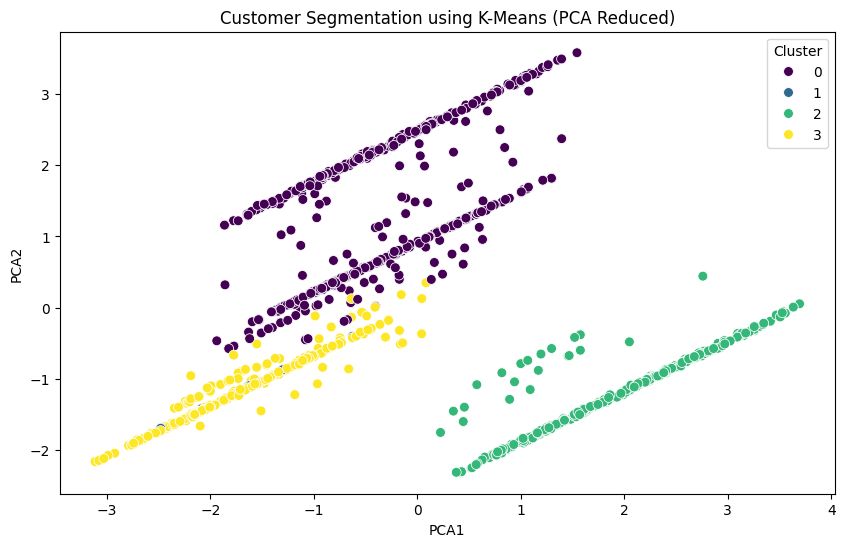

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convert to DataFrame for plotting
df_plot = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_plot['Cluster'] = df_numeric['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Segmentation using K-Means (PCA Reduced)')
plt.show()


**b)Elbow Method for Optimal Cluster Selection :**If you haven't determined the ideal number of clusters yet, use the elbow method.

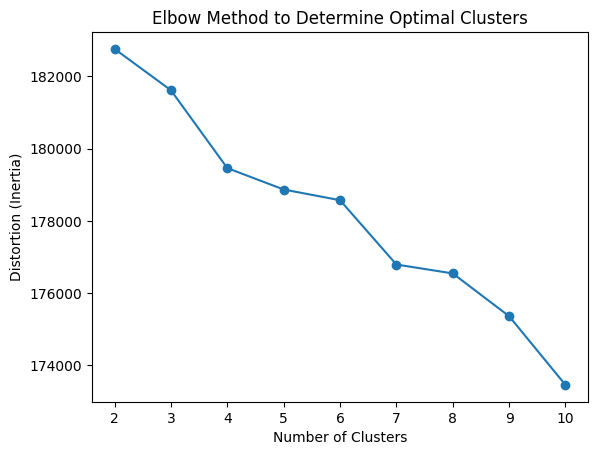

In [23]:
distortions = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()


**Step:6 Save the results: **After clustering and evaluation, save the results for reporting.

In [24]:
df_numeric[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)
print("Customer segmentation results saved to Customer_Segments.csv")


Customer segmentation results saved to Customer_Segments.csv


**Download Clustering/segmentation results:**

In [26]:
from google.colab import files

# Download the file to your local system
files.download('Customer_Segments.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>